In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import os
import sys
from pathlib import Path
sys.path.append('/lab/barcheese01/smaffa/coTISja/src')

from scripts.filter_utils import *
import re

# Generate saved tables

In [13]:
experiment_table, sample_df, replicate_df = load_experiment_manifest()
samples = experiment_table['sample'].tolist()
codon_order = ['ATG', 'ATA', 'ATC', 'ATT', 'ACG', 'AAG', 'AGG', 'GTG', 'TTG', 'CTG']

In [4]:
def load_gtf_annotations(gtf_path=GTF_FILE, features=['start_codon', 'CDS', 'UTR']):
    annotation_tables = []
    if isinstance(features, str):
        features = [features]
    for feature in features:
        print(f'Reading {feature}s from {gtf_path}')
        annotation_tables.append(load_transcript_annotations(gtf_path=gtf_path, feature_type=feature))
    if len(annotation_tables) == 1:
        return annotation_tables[0]
    else:
        return annotation_tables

gtf_annotations = load_gtf_annotations()
start_codon_annotations, cds_annotations, utr_annotations = gtf_annotations

Reading start_codons from /lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf
Reading CDSs from /lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf
Reading UTRs from /lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf


In [5]:
transcript_to_genome_pos = get_canonical_genome_positions(cds_annotations=cds_annotations)
transcript_to_utr_length = get_utr_lengths(cds_annotations=cds_annotations, utr_annotations=utr_annotations)
transcript_to_start_codon = get_start_codons(start_codon_annotations=start_codon_annotations, genome_file=GENOME_FILE)
transcript_to_protein = get_protein_products(protein_fasta=PROTEIN_FASTA)

100%|██████████| 221201/221201 [02:07<00:00, 1735.32it/s]


Reading protein sequences from /lab/barcheese01/smaffa/coTISja/data/reference/gencode.v49.pc_translations.fa


In [9]:
LOAD_SEQUENCES = True
sequences = ['AASeq'] #['Seq', 'AASeq']

sample_to_filtered_tis = dict()

for sample in tqdm(samples):
    filt_table = pd.read_csv(experiment_table.set_index('sample').loc[sample, 'filtered_file'])

    # add undetected canonical start codons
    imputed_table = impute_missing_canonical_starts(
        filt_table, 
        genome_pos=transcript_to_genome_pos, 
        utr_lengths=transcript_to_utr_length, 
        start_codons=transcript_to_start_codon,
        protein_products=transcript_to_protein
    )

    # combine with the detected TISs
    filt_table = pd.concat([
        filt_table, imputed_table
    ], axis=0, ignore_index=True)
    filt_table['Imputed'] = filt_table['Imputed'].fillna(False)

    if LOAD_SEQUENCES:
        pred_table = pd.read_csv(experiment_table.set_index('sample').loc[sample, 'predict_file'], sep='\t', usecols=['Tid', 'GenomePos', 'Start'] + sequences)
        # pull AA translations for the non-canonical TISs from the ribotish outputs
        merged_table = filt_table.merge(pred_table, left_on=['Tid', 'GenomePos', 'Start'], right_on=['Tid', 'GenomePos', 'Start'], how='left')

        # pull AA translations for the canonical TISs from the protein annotations
        merged_table.loc[
            merged_table['Imputed'], 'AASeq'
        ] = transcript_to_protein.set_index('Tid').reindex(
            index=merged_table[merged_table['Imputed']]['Tid'].tolist()
        )['AASeq'].tolist()
    else:
        merged_table = filt_table
    sample_to_filtered_tis[sample] = merged_table
all_tis_df= pd.concat(sample_to_filtered_tis, axis=0).reset_index(names=['Sample', 'drop']).drop(['drop'], axis=1)

100%|██████████| 6/6 [00:52<00:00,  8.68s/it]


In [141]:
sample_normalization_factors = pd.Series(
    {s: tmm_normalization_factors(s, 'HeLa') for s in samples}, name='SampleScaleFactor'
)
sample_normalization_factors.index.name = 'Sample'
all_tis_df = all_tis_df.merge(sample_normalization_factors, left_on='Sample', right_index=True)

/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log

In [142]:
all_tis_df['IsoformID'] = all_tis_df['Tid'] + ':' + all_tis_df['Start'].astype(int).astype(str)
all_tis_df['TIS_ID'] = all_tis_df['Gid'] + ':' + all_tis_df['GenomeStart']
isoform_annotation_df = all_tis_df[['IsoformID', 'Tid', 'Symbol', 'GenomePos', 'Start', 'StartCodon', 'RecatTISType', 'MANE_Select', 'transcript_support_level']].drop_duplicates()
tis_annotation_df = all_tis_df[['TIS_ID', 'Tid', 'Symbol', 'GenomePos', 'Start', 'StartCodon', 'RecatTISType', 'MANE_Select', 'transcript_support_level']].drop_duplicates()

In [144]:
all_tis_df[all_tis_df['MANE_Select']].to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered_mane_only.csv', index=False)
all_tis_df.drop(['AASeq'], axis=1).to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered.csv', index=False)
all_tis_df.to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered_with_protein_seq.csv', index=False)

In [182]:
paired_isoform_df = all_tis_df[~all_tis_df['RecatTISType'].isin(['Annotated'])].drop_duplicates(subset=['Sample', 'IsoformID']).merge(
    all_tis_df[all_tis_df['RecatTISType'].isin(['Annotated'])].drop_duplicates(subset=['Sample', 'Tid'])[
        ['Sample', 'IsoformID', 'Tid', 'Start', 'StartCodon', 'TISCounts', 'NormTISCounts']
    ].rename({
        'IsoformID': 'CanonicalIsoformID', 'Start':'CanonicalStart', 
        'StartCodon':'CanonicalStartCodon', 'TISCounts':'CanonicalTISCounts', 
        'NormTISCounts':'CanonicalNormTISCounts'}, axis=1),
    how='left'
).dropna(subset=['CanonicalIsoformID', 'CanonicalStart', 'CanonicalStartCodon', 'CanonicalTISCounts', 'CanonicalNormTISCounts'])
paired_isoform_df['FoldChangeFromCanonical'] = (paired_isoform_df['TISCounts']+1) / (paired_isoform_df['CanonicalTISCounts']+1)
paired_isoform_df['LogFoldChangeFromCanonical'] = np.log2(paired_isoform_df['FoldChangeFromCanonical'])
paired_isoform_df['DistanceToCanonical'] = (paired_isoform_df['CanonicalStart'] - paired_isoform_df['Start']).abs()
paired_isoform_df = paired_isoform_df.assign(
    SampleNormalizedLFC = lambda x: np.log2(((x['TISCounts'] * x['SampleScaleFactor']) + 1) / ((x['CanonicalTISCounts'] * x['SampleScaleFactor']) + 1))
)
paired_isoform_df.to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_paired_tis.csv', index=False)

## Load from saved files

In [14]:
all_tis_df = pd.read_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered_with_protein_seq.csv')
paired_isoform_df = pd.read_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_paired_tis.csv')
isoform_annotation_df = all_tis_df[['IsoformID', 'Tid', 'Symbol', 'GenomePos', 'Start', 'StartCodon', 'RecatTISType', 'MANE_Select', 'transcript_support_level']].drop_duplicates()
genomic_tis_annotation_df = all_tis_df[['TIS_ID', 'Symbol', 'StartCodon']].drop_duplicates()
gene_annotation_df = all_tis_df[['Gid', 'Symbol']].drop_duplicates()

isoform_to_tis = all_tis_df[['IsoformID', 'TIS_ID']].drop_duplicates()
isoform_to_gene = all_tis_df[['IsoformID', 'Gid']].drop_duplicates()
tis_to_gene = all_tis_df[['TIS_ID', 'Gid']].drop_duplicates()
gene_to_symbol = all_tis_df[['Gid', 'Symbol']].drop_duplicates()

In [ ]:
# can redefine these varables based on some other filter for 1 transcript per gene, and the downstream analysis should work
tis_df = all_tis_df[all_tis_df['MANE_Select']]
paired_tis_df = paired_isoform_df[paired_isoform_df['MANE_Select']]

# Stringency

## Relative usage of CUG to AUG

Text(0.5, 1.0, 'Relative CUG / canonical AUG usage per transcript')

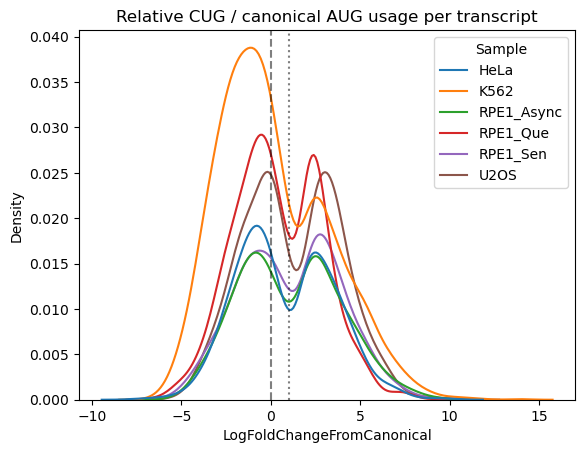

In [16]:
sns.kdeplot(
    paired_tis_df[paired_tis_df['StartCodon'] == 'CTG'],
    hue='Sample',
    x='LogFoldChangeFromCanonical'
)
plt.axvline(0, linestyle='dashed', color='black', alpha=0.5)
plt.axvline(1, linestyle='dotted', color='black', alpha=0.5)
plt.title('Relative CUG / canonical AUG usage per transcript')

Text(0.5, 1.0, 'Relative upstream CUG / canonical AUG usage per transcript')

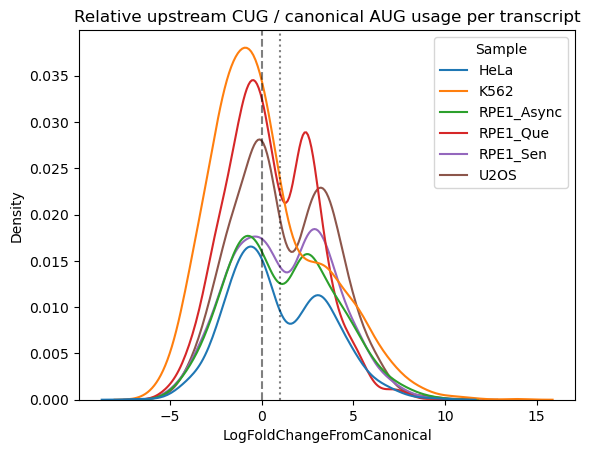

In [17]:
sns.kdeplot(
    paired_tis_df[
        (paired_tis_df['StartCodon'] == 'CTG') & 
        (paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']))
    ],
    hue='Sample',
    x='LogFoldChangeFromCanonical'
)
plt.axvline(0, linestyle='dashed', color='black', alpha=0.5)
plt.axvline(1, linestyle='dotted', color='black', alpha=0.5)
plt.title('Relative upstream CUG / canonical AUG usage per transcript')

0 signifies equal reads from upstream CUG and canonical AUG; less than 0 signifies more translation from the canonical start site; greater than 0 signfies more translation from the upstream CUG. 

There is a larger probability mass around slightly less than 0, and a longer tail on the positive end, which suggests that most transcript experience primarily canonical translation, but the ones that have upstream translation have strong translation initiation at those sites. If we were to design an supervised learning algorithm to predict translation efficiency/usage, I would use the larger mode as positive examples and the smaller mode + in-frame extension TISs without reads as negative examples.

What explains why this isn't symmetic around 0? Maybe because examples of (upstream/annotated) are included if upstream is sufficiently high in readcounts, but examples where upstream is not sufficiently high aren't reported by ribotish filtering (e.g. we have no instances of (0/10) but we have instances of (10/0))

Good to see that there is nothing special about 1 - it is only artifactual that 1 appears to be the breakpoint between modes when plotted over TIS all categories

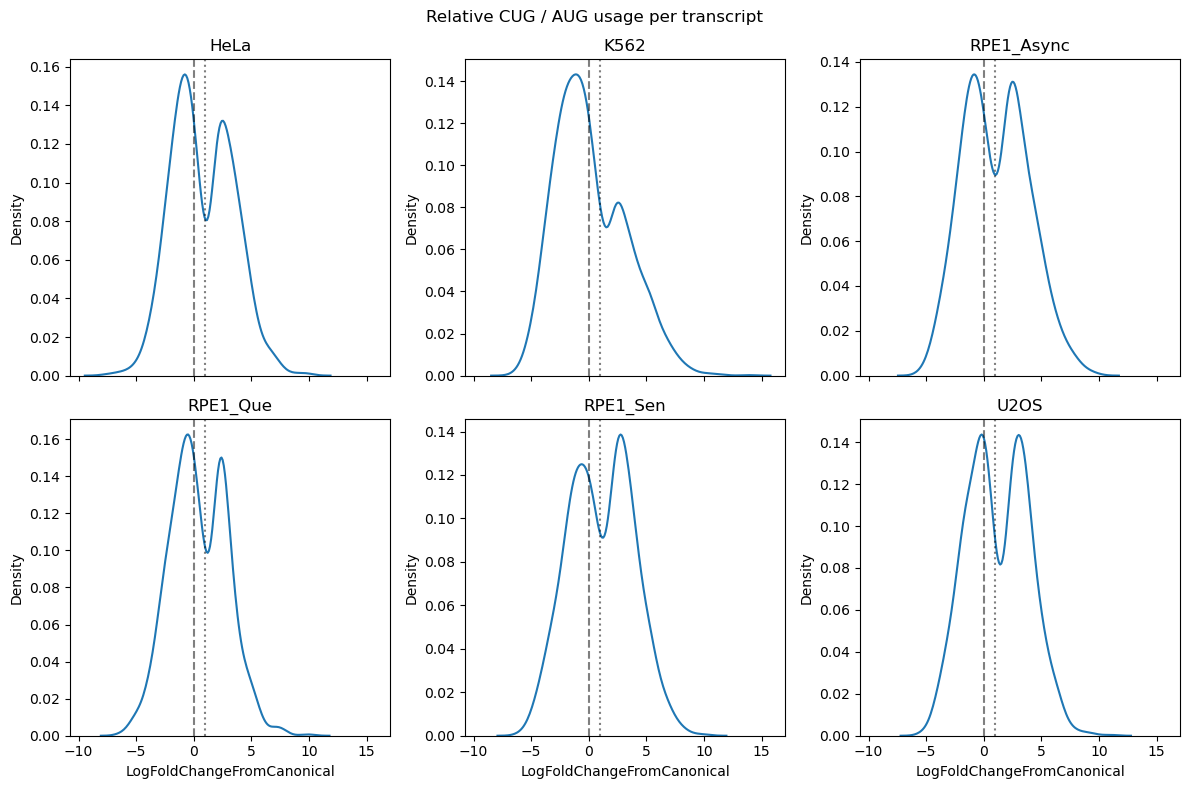

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.kdeplot(
        paired_tis_df[
            (paired_tis_df['StartCodon'] == 'CTG') & 
            # (paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])) &
            (paired_tis_df['Sample'] == s)
            ],
        x='LogFoldChangeFromCanonical',
        ax=axs[i]
    )
    axs[i].axvline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].axvline(1, linestyle='dotted', color='black', alpha=0.5)
    axs[i].set_title(s)

plt.suptitle('Relative CUG / AUG usage per transcript')
plt.tight_layout()
plt.show()

This suggests that detected truncations are biased towards higher translation than their canonical sites, compared to extensions. (To whatever extent ribotish is capturing putative aTISs. Hard to make broad generalizations because we are analyzing over only transcripts with a detected aTIS).

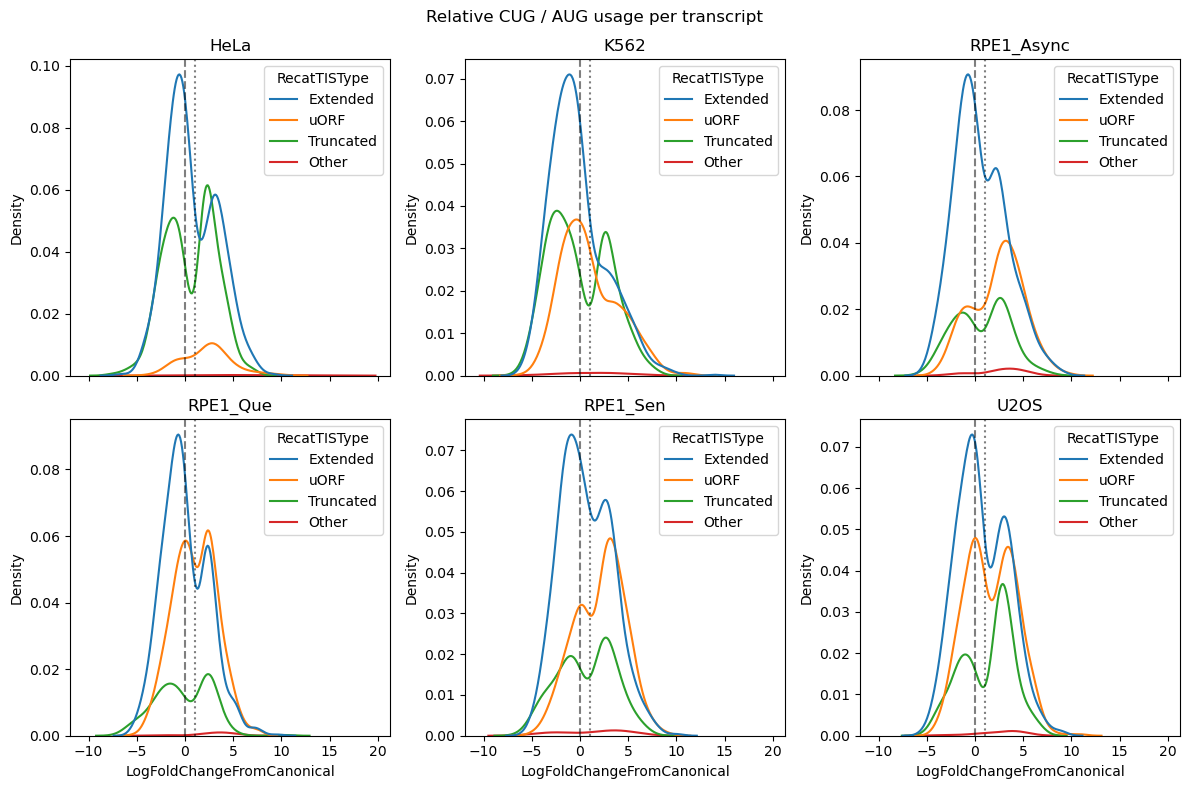

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.kdeplot(
        paired_tis_df[
            (paired_tis_df['StartCodon'] == 'CTG') & 
            # (mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])) &
            (paired_tis_df['Sample'] == s)
            ],
        hue='RecatTISType', hue_order=['Extended', 'uORF', 'Truncated', 'Other'],
        x='LogFoldChangeFromCanonical',
        ax=axs[i]
    )
    axs[i].axvline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].axvline(1, linestyle='dotted', color='black', alpha=0.5)
    axs[i].set_title(s)

plt.suptitle('Relative CUG / AUG usage per transcript')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Upstream codon usage foldchanges')

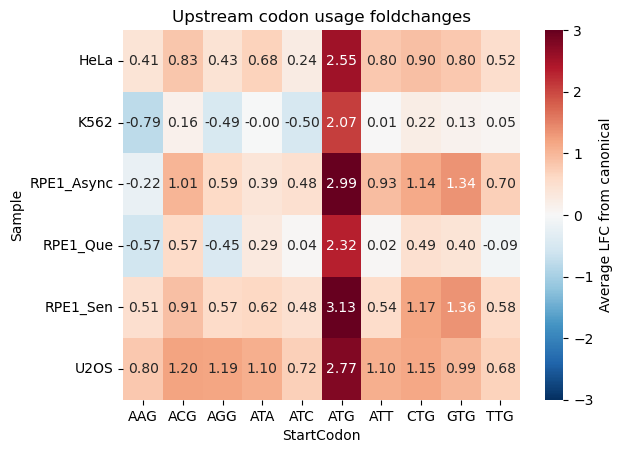

In [20]:
sns.heatmap(
    paired_tis_df[paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])].pivot_table(
        index='Sample', columns='StartCodon', values='LogFoldChangeFromCanonical', aggfunc='mean'
    ), cmap='RdBu_r', vmin=-3, vmax=3, annot=True, fmt='.2f', cbar_kws={'label': 'Average LFC from canonical'}
)
plt.title('Upstream codon usage foldchanges')

NOTE: ONLY COMPARE ABOVE ACROSS CODONS, NOT SAMPLES. 

Currently this cannot be compared across cell lines, because individual transcripts have not been adjusted for relative differences in transcript abundance. The fairest comparison is to normalize each transcript as if it had the same transcript abundance in each cell line

Text(0.5, 1.0, 'Upstream codon usage foldchanges')

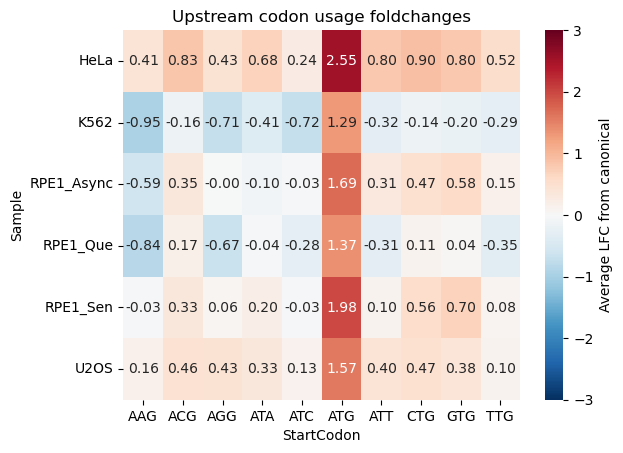

In [21]:
sns.heatmap(
    paired_tis_df[paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])].pivot_table(
        index='Sample', columns='StartCodon', values='SampleNormalizedLFC', aggfunc='mean'
    ), cmap='RdBu_r', vmin=-3, vmax=3, annot=True, fmt='.2f', cbar_kws={'label': 'Average LFC from canonical'}
)
plt.title('Upstream codon usage foldchanges')

In [23]:
noncanonical_tis_counts = paired_tis_df.pivot_table(index='Sample', columns='IsoformID', values='TISCounts').fillna(0)
canonical_tis_counts = paired_tis_df.pivot_table(index='Sample', columns='IsoformID', values='CanonicalTISCounts').fillna(0)
rnaseq_abundance = paired_tis_df.pivot_table(index='Sample', columns='IsoformID', values='GeneRNASeqCounts').fillna(0)

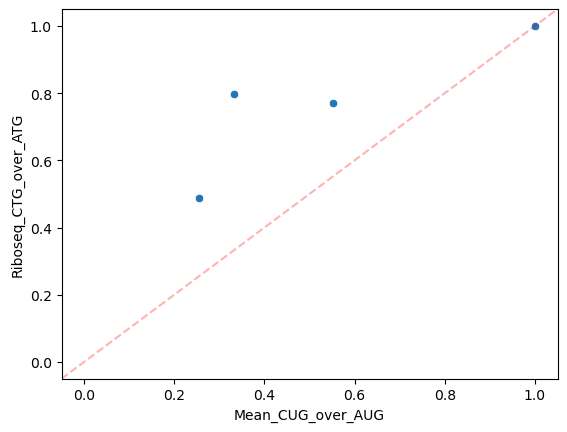

In [25]:
stringency_table = pd.read_csv('/lab/barcheese01/aTIS_data/stringency/CUG_AUG_stringency_16celllines.csv')

relative_cug_aug = paired_tis_df[
    (paired_tis_df['StartCodon'] == 'CTG')
].groupby('Sample')['SampleNormalizedLFC'].mean()
relative_cug_aug = 2 ** relative_cug_aug
relative_cug_aug = relative_cug_aug / relative_cug_aug.loc['HeLa']
relative_cug_aug = pd.DataFrame(relative_cug_aug.rename('Riboseq_CTG_over_ATG'))

stringency_df = stringency_table.merge(
    relative_cug_aug.rename({'RPE1_Async': 'RPE1'}), left_on='Cell_line', right_index=True
)

sns.scatterplot(stringency_df, x='Mean_CUG_over_AUG', y='Riboseq_CTG_over_ATG')
plt.gca().axline((0, 0), slope=1, linestyle='dashed', color='red', alpha=0.3)

# Relative translation conditional on upstream start codon

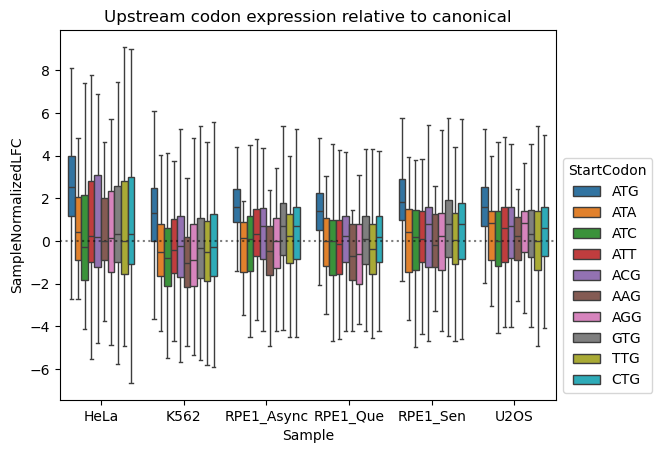

In [30]:
sns.boxplot(
    paired_tis_df[paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])],
    x='Sample', y='SampleNormalizedLFC', hue='StartCodon', showfliers=False,
    hue_order=codon_order
)
plt.gca().axhline(0, linestyle='dotted', color='black', alpha=0.5)
plt.title('Upstream codon expression relative to canonical')
plt.xlabel('Sample')
plt.gca().get_legend().set_loc('lower left')
plt.gca().get_legend().set_bbox_to_anchor((1, 0))

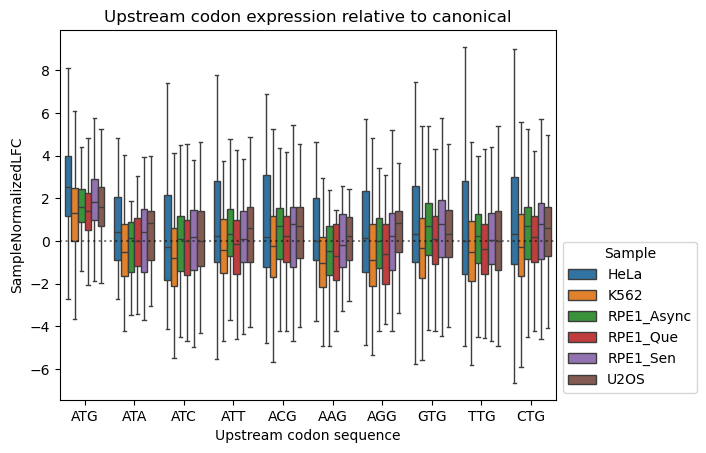

In [29]:
sns.boxplot(
    paired_tis_df[paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])],
    x='StartCodon', y='SampleNormalizedLFC', hue='Sample', showfliers=False,
    order=codon_order
)
plt.gca().axhline(0, linestyle='dotted', color='black', alpha=0.5)
plt.title('Upstream codon expression relative to canonical')
plt.xlabel('Upstream codon sequence')
plt.gca().get_legend().set_loc('lower left')
plt.gca().get_legend().set_bbox_to_anchor((1, 0))

# Relative translation conditional on UTR length / distance between upstream vs. canonical

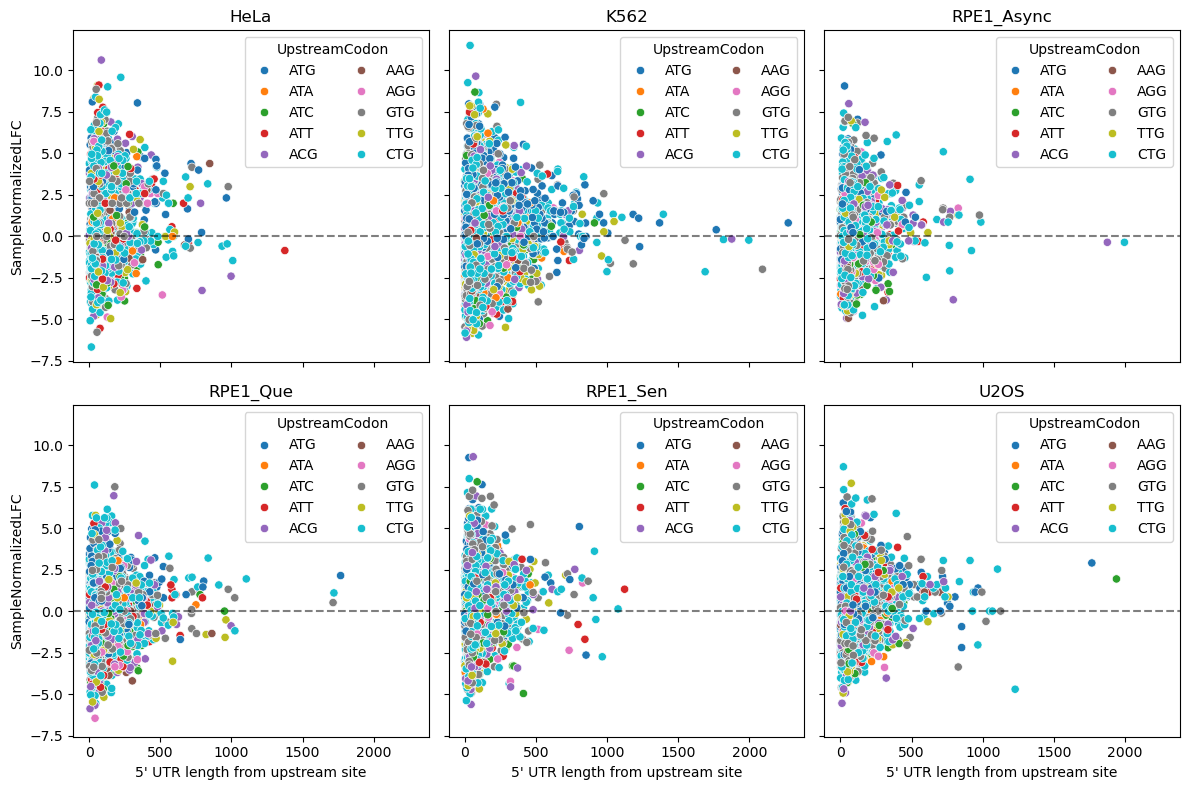

In [34]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        paired_tis_df[
            paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (paired_tis_df['Sample'] == s)
        ],
        x='Start', y='SampleNormalizedLFC', hue='StartCodon', hue_order=codon_order,
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(s)
    axs[i].set_xlabel("5' UTR length from upstream site")
    h, l = axs[i].get_legend_handles_labels()
    axs[i].legend(h, l, title='UpstreamCodon', ncols=2)

plt.tight_layout()
plt.show()

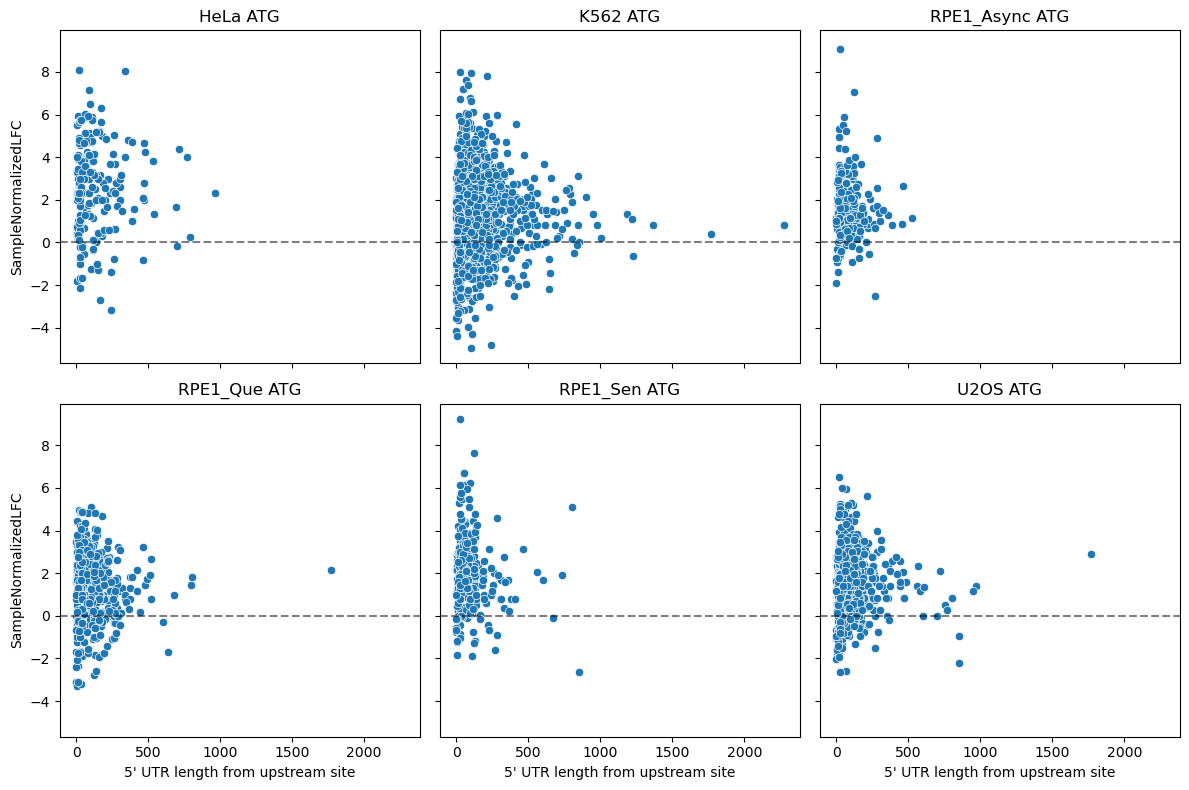

In [39]:
# control for start codon
codon = 'ATG'
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        paired_tis_df[
            paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (paired_tis_df['Sample'] == s) &
            (paired_tis_df['StartCodon'] == codon)
        ],
        x='Start', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(f'{s} {codon}')
    axs[i].set_xlabel("5' UTR length from upstream site")

plt.tight_layout()
plt.show()

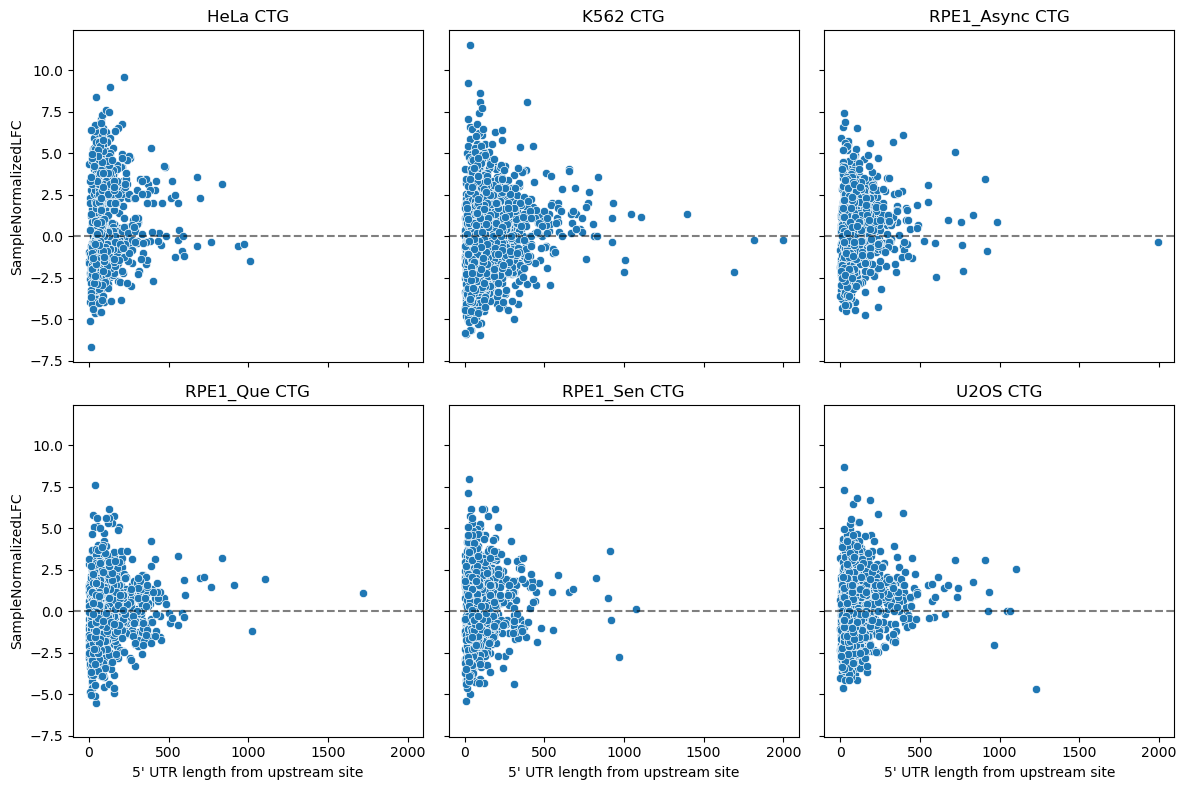

In [38]:
# control for start codon
codon = 'CTG'
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        paired_tis_df[
            paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (paired_tis_df['Sample'] == s) & 
            (paired_tis_df['StartCodon'] == codon)
        ],
        x='Start', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(f'{s} {codon}')
    axs[i].set_xlabel("5' UTR length from upstream site")

plt.tight_layout()
plt.show()

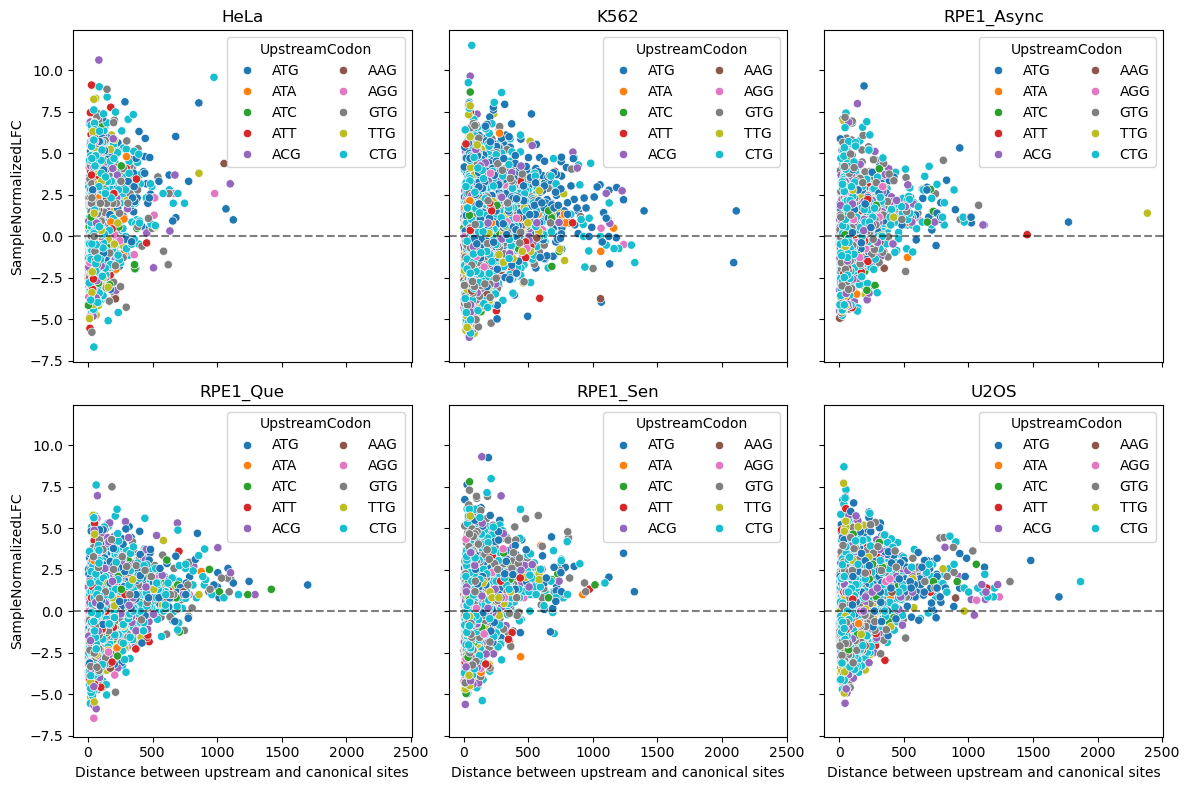

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        paired_tis_df[
            paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (paired_tis_df['Sample'] == s)
        ].assign(DistanceToCanonicalBP = lambda x: x['CanonicalStart'] - x['Start']),
        x='DistanceToCanonicalBP', y='SampleNormalizedLFC', hue='StartCodon', hue_order=codon_order,
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(s)
    axs[i].set_xlabel("Distance between upstream and canonical sites")
    h, l = axs[i].get_legend_handles_labels()
    axs[i].legend(h, l, title='UpstreamCodon', ncols=2)

plt.tight_layout()
plt.show()

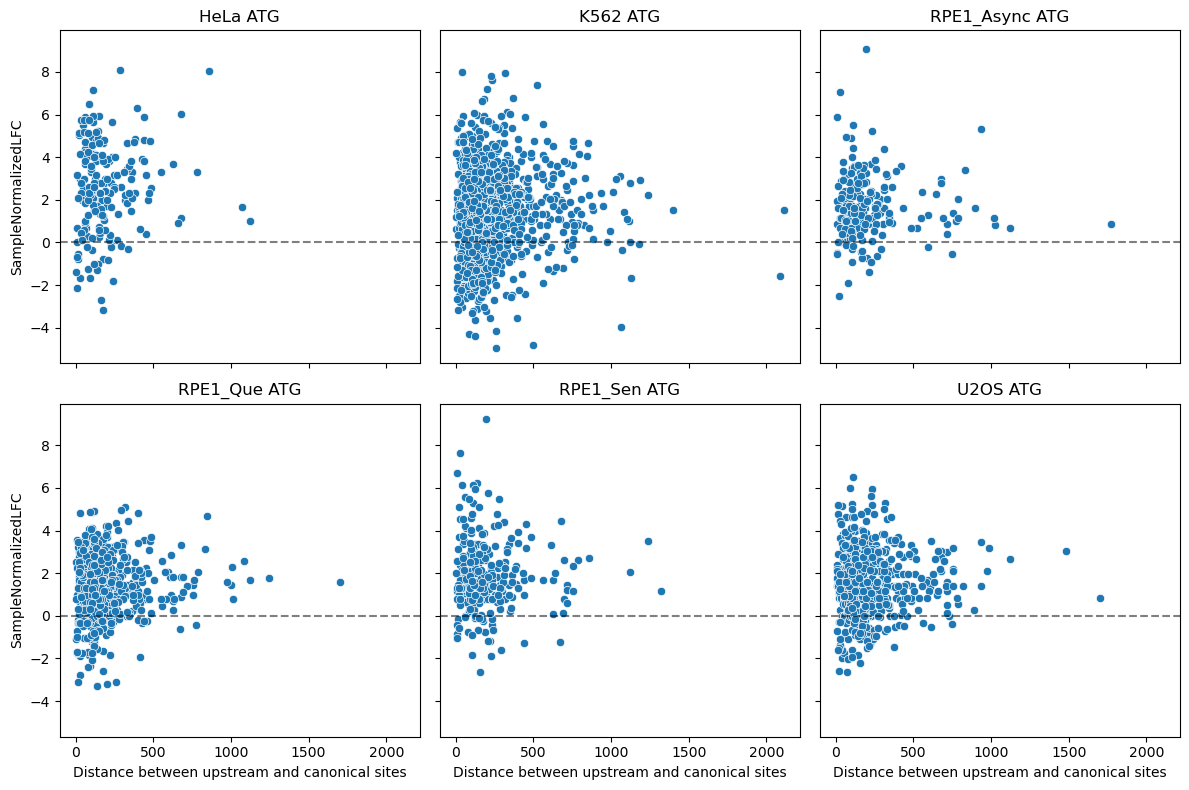

In [42]:
codon = 'ATG'
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        paired_tis_df[
            paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (paired_tis_df['Sample'] == s) & 
            (paired_tis_df['StartCodon'] == codon)
        ].assign(DistanceToCanonicalBP = lambda x: x['CanonicalStart'] - x['Start']),
        x='DistanceToCanonicalBP', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(f'{s} {codon}')
    axs[i].set_xlabel("Distance between upstream and canonical sites")

plt.tight_layout()
plt.show()

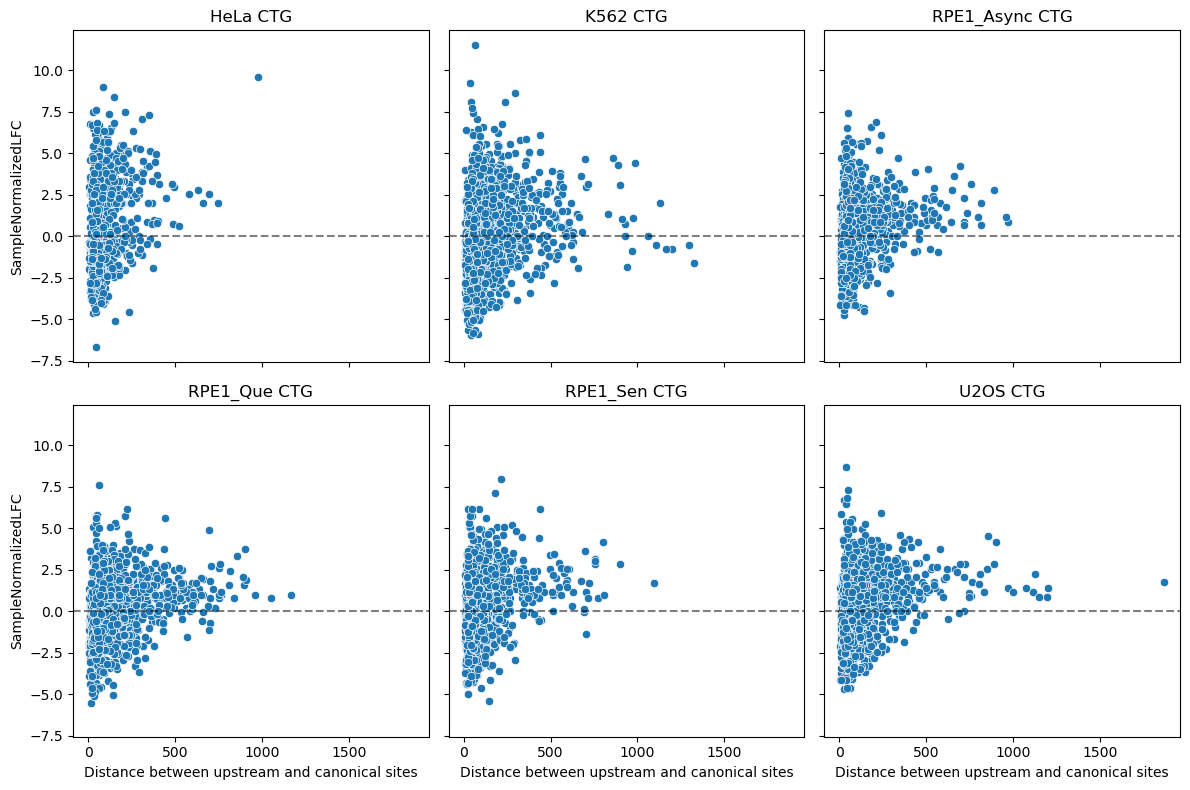

In [44]:
codon = 'CTG'
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        paired_tis_df[
            paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (paired_tis_df['Sample'] == s) & 
            (paired_tis_df['StartCodon'] == codon)
        ].assign(DistanceToCanonicalBP = lambda x: x['CanonicalStart'] - x['Start']),
        x='DistanceToCanonicalBP', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(f'{s} {codon}')
    axs[i].set_xlabel("Distance between upstream and canonical sites")

plt.tight_layout()
plt.show()

## Length of upstream 5' UTR

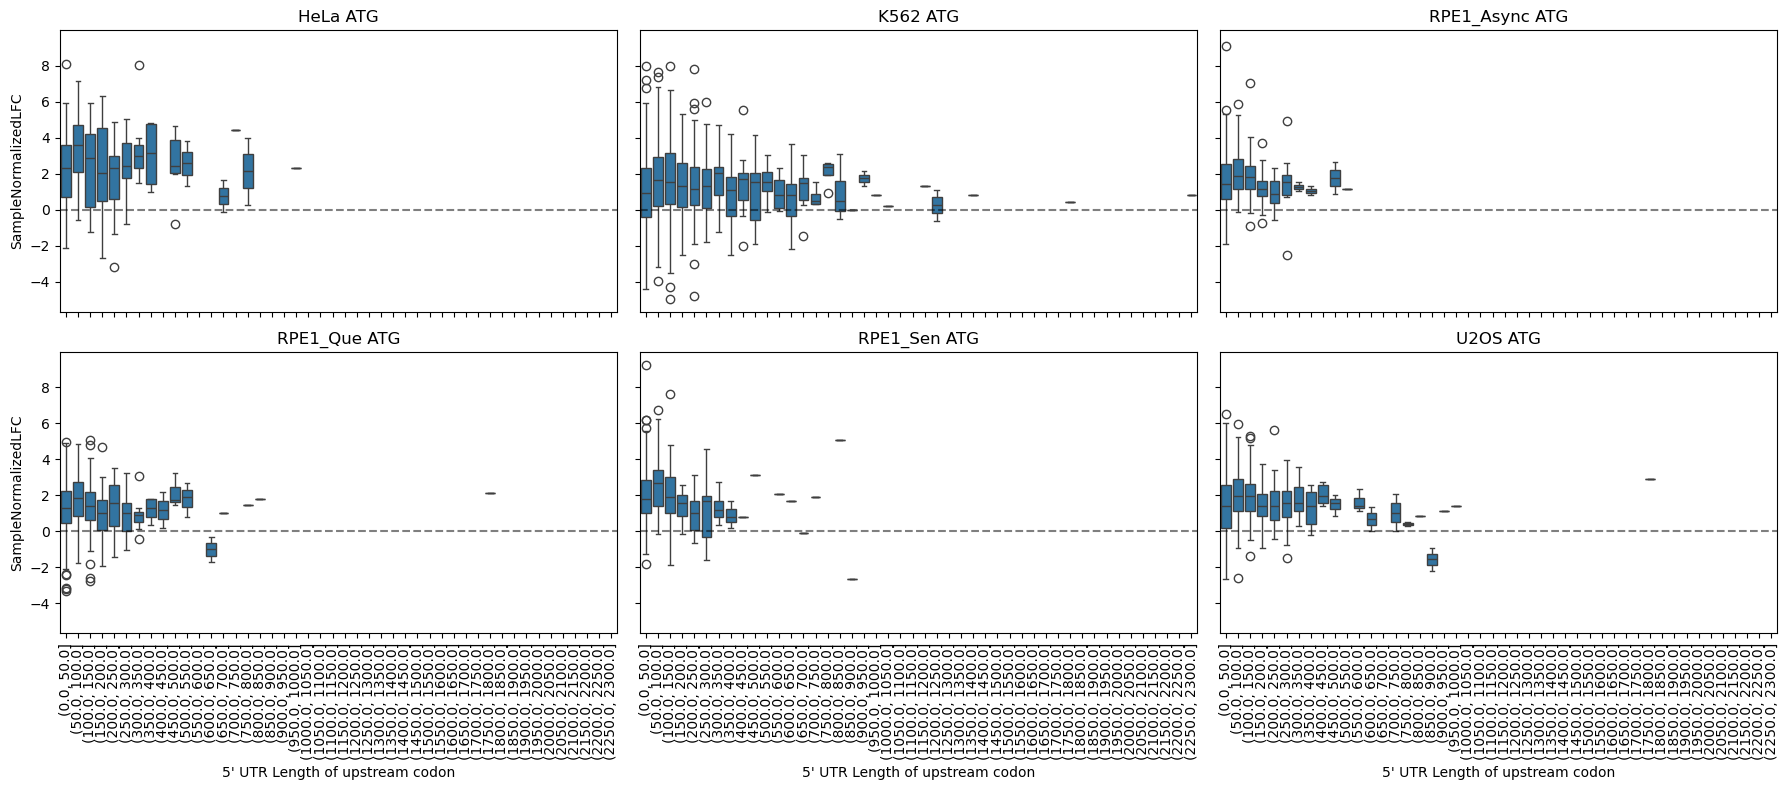

In [190]:
utr_binned_tis_df = paired_tis_df[
    paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])
].copy()
utr_binned_tis_df['UTRLengthBin'] = pd.cut(utr_binned_tis_df['Start'], bins=np.arange(0, utr_binned_tis_df['Start'].max() + 50, 50))

codon = 'ATG'
fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.boxplot(
        utr_binned_tis_df[
            (utr_binned_tis_df['Sample'] == s) & 
            (utr_binned_tis_df['StartCodon'] == codon)
        ],
        x='UTRLengthBin', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(f'{s} {codon}')
    axs[i].set_xlabel("5' UTR Length of upstream codon")
    axs[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()


## Length of canonical 5' UTR

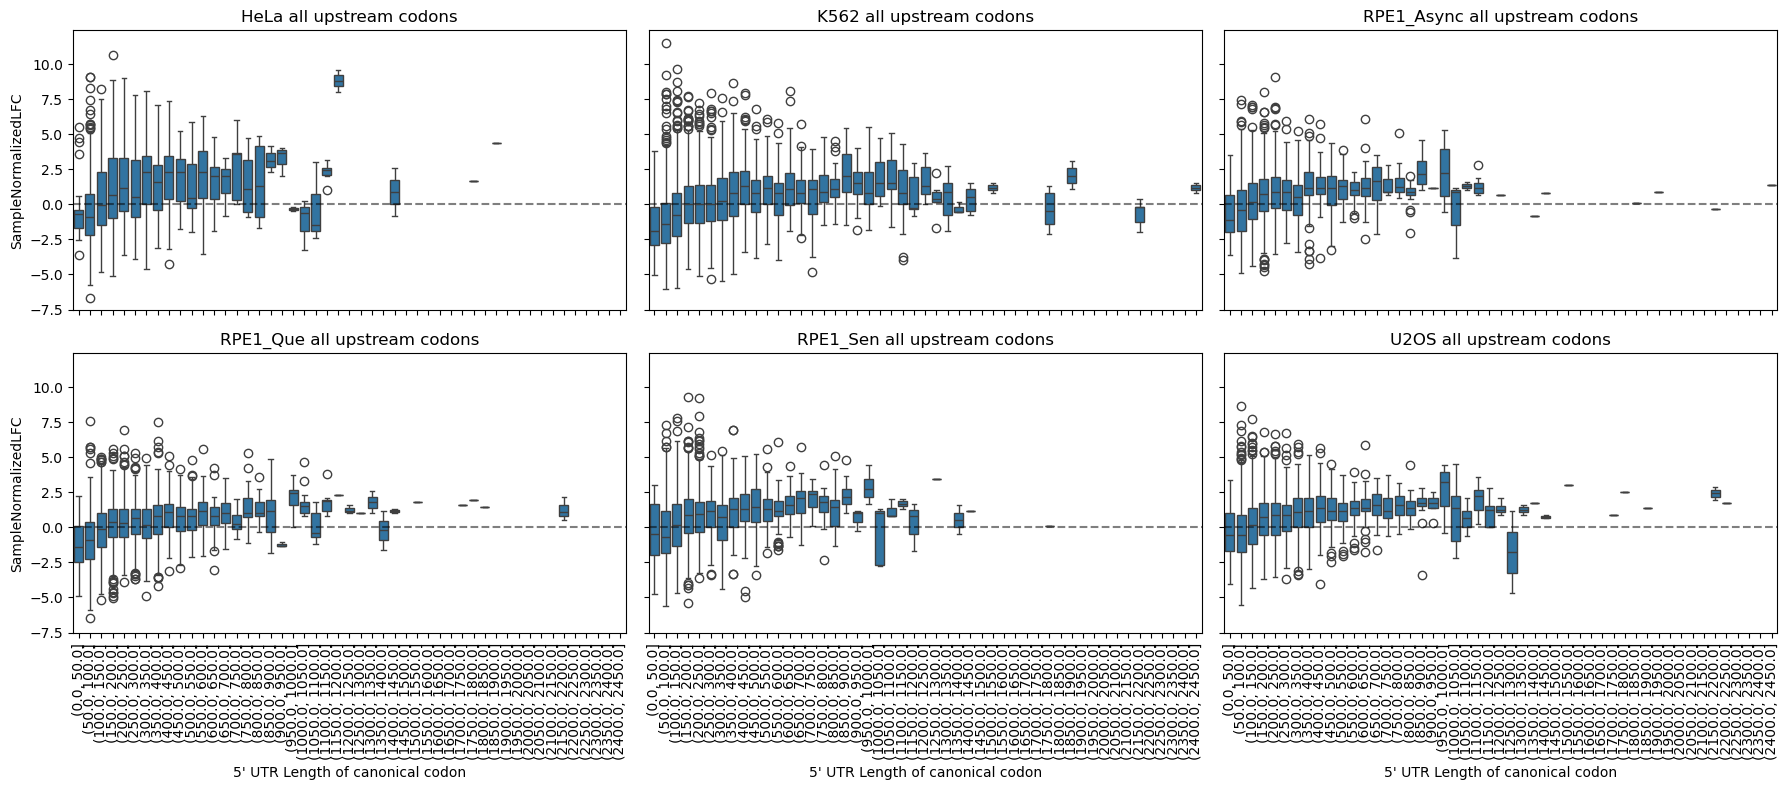

In [192]:
utr_binned_tis_df = paired_tis_df[
    paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])
].copy()
utr_binned_tis_df['UTRLengthBin'] = pd.cut(utr_binned_tis_df['CanonicalStart'], bins=np.arange(0, utr_binned_tis_df['CanonicalStart'].max() + 50, 50))

fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.boxplot(
        utr_binned_tis_df[
            (utr_binned_tis_df['Sample'] == s)
        ],
        x='UTRLengthBin', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(f'{s} all upstream codons')
    axs[i].set_xlabel("5' UTR Length of canonical codon")
    axs[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

# Breakdown of UTR length relationship with translation efficiency, with start codon and sample as covariates

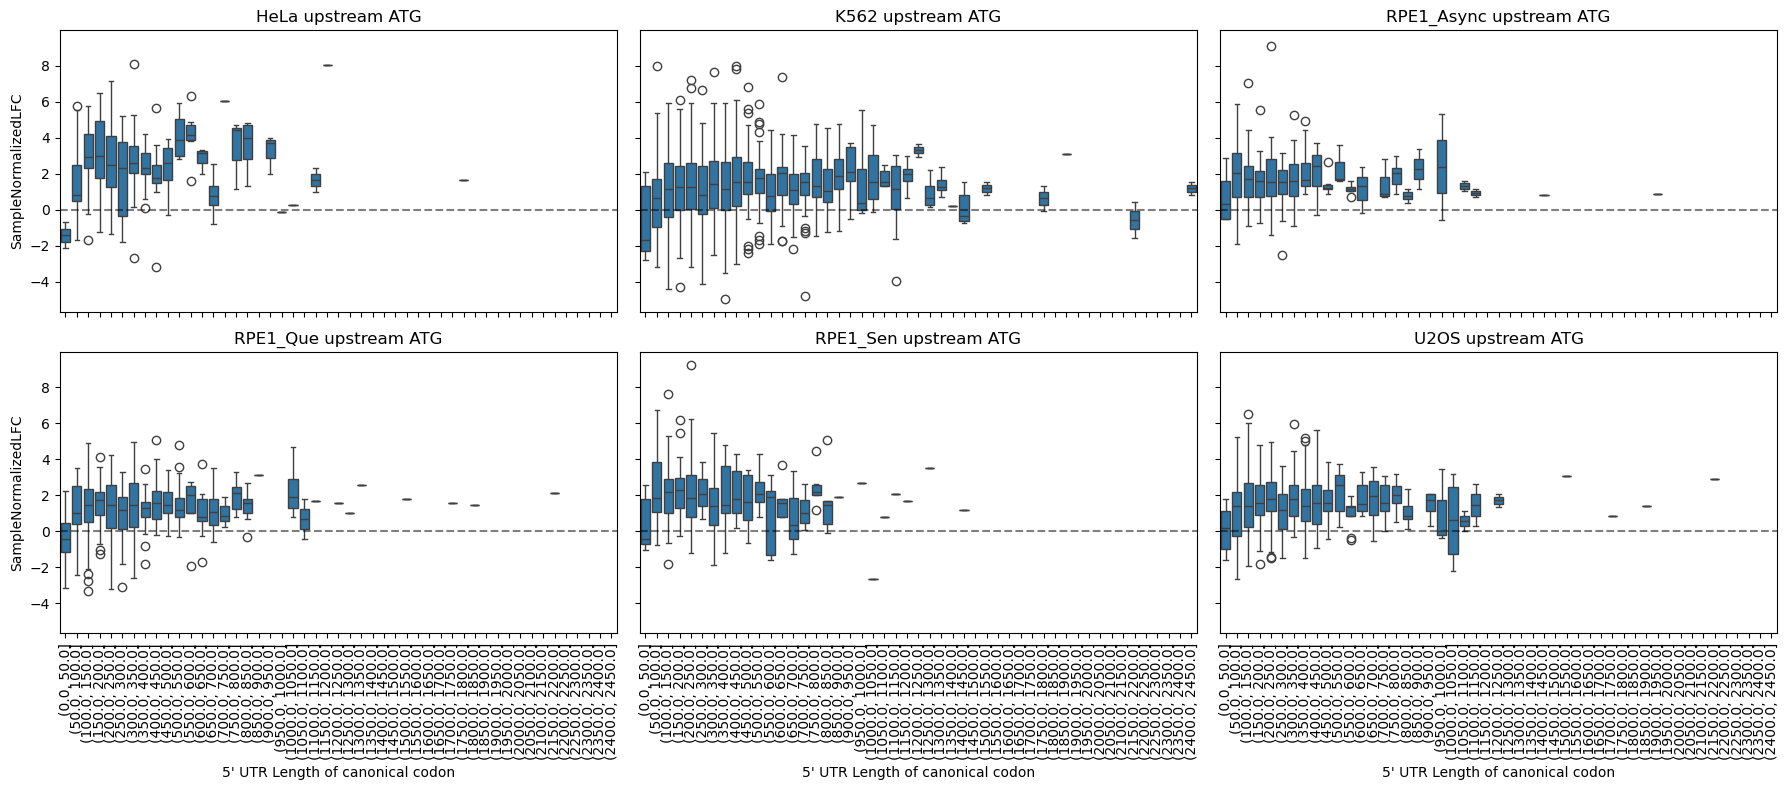

In [189]:
utr_binned_tis_df = paired_tis_df[
    paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])
].copy()
utr_binned_tis_df['UTRLengthBin'] = pd.cut(utr_binned_tis_df['CanonicalStart'], bins=np.arange(0, utr_binned_tis_df['CanonicalStart'].max() + 50, 50))

codon = 'ATG'
fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.boxplot(
        utr_binned_tis_df[
            (utr_binned_tis_df['Sample'] == s) & 
            (utr_binned_tis_df['StartCodon'] == codon)
        ],
        x='UTRLengthBin', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(f'{s} upstream {codon}')
    axs[i].set_xlabel("5' UTR Length of canonical codon")
    axs[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()


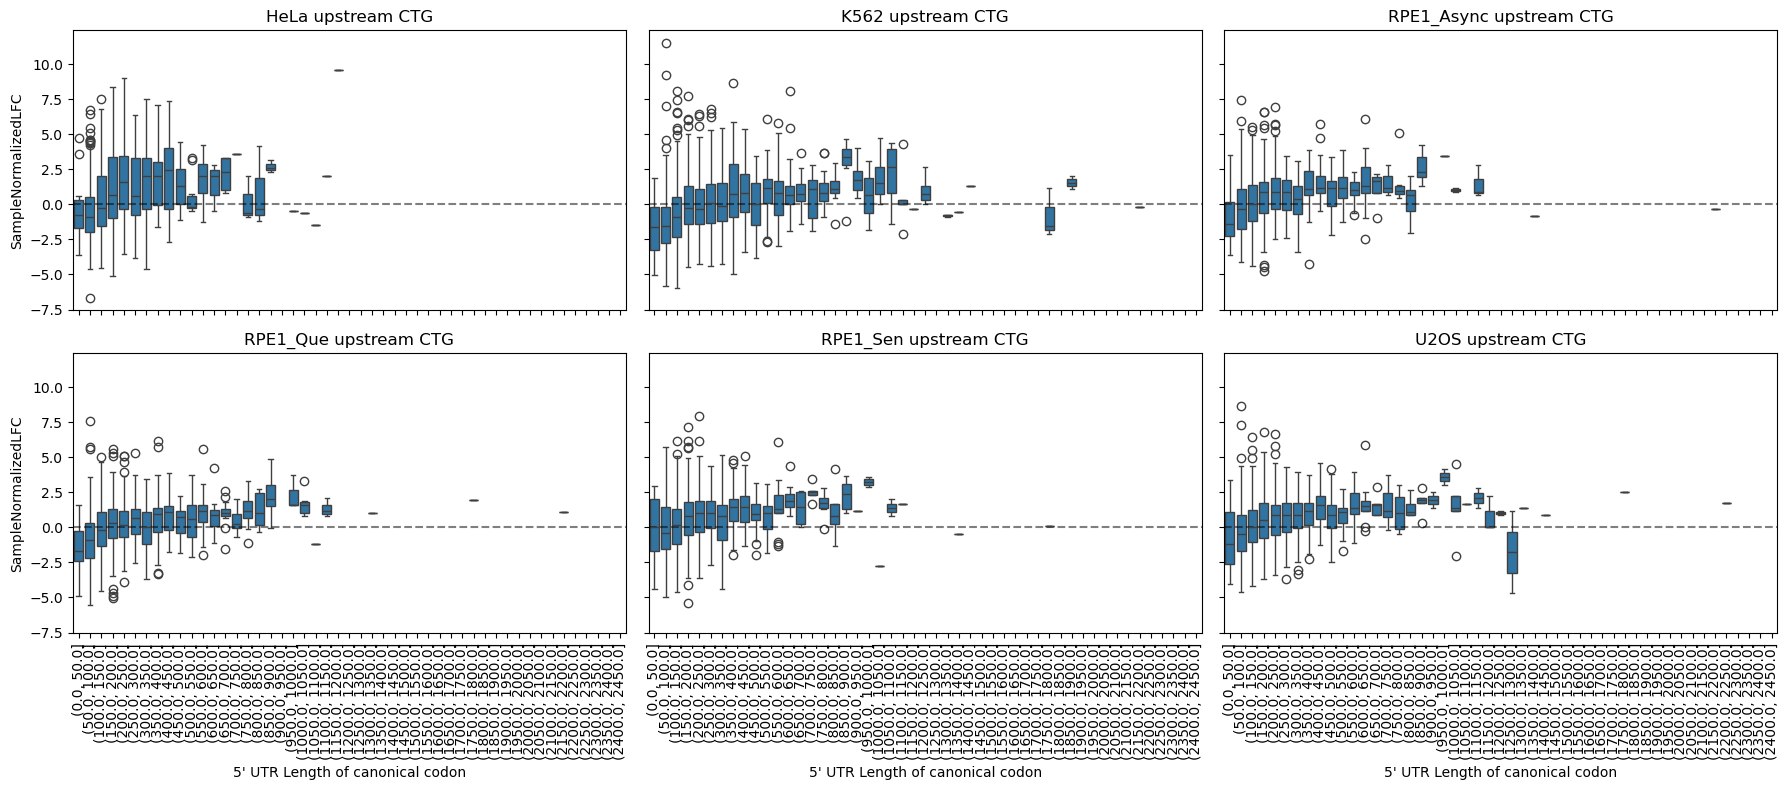

In [188]:
utr_binned_tis_df = paired_tis_df[
    paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])
].copy()
utr_binned_tis_df['UTRLengthBin'] = pd.cut(utr_binned_tis_df['CanonicalStart'], bins=np.arange(0, utr_binned_tis_df['CanonicalStart'].max() + 50, 50))

codon = 'CTG'
fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.boxplot(
        utr_binned_tis_df[
            (utr_binned_tis_df['Sample'] == s) & 
            (utr_binned_tis_df['StartCodon'] == codon)
        ],
        x='UTRLengthBin', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(f'{s} upstream {codon}')
    axs[i].set_xlabel("5' UTR Length of canonical codon")
    axs[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()


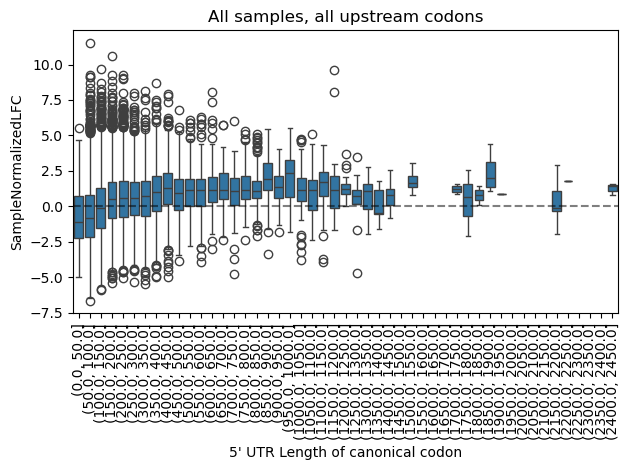

In [187]:
utr_binned_tis_df = paired_tis_df[
    paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])
].copy()
utr_binned_tis_df['UTRLengthBin'] = pd.cut(utr_binned_tis_df['CanonicalStart'], bins=np.arange(0, utr_binned_tis_df['CanonicalStart'].max() + 50, 50))

sns.boxplot(
    utr_binned_tis_df,
    x='UTRLengthBin', y='SampleNormalizedLFC',
)
plt.gca().axhline(0, linestyle='dashed', color='black', alpha=0.5)
plt.gca().set_title(f'All samples, all upstream codons')
plt.gca().set_xlabel("5' UTR Length of canonical codon")
plt.gca().tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()


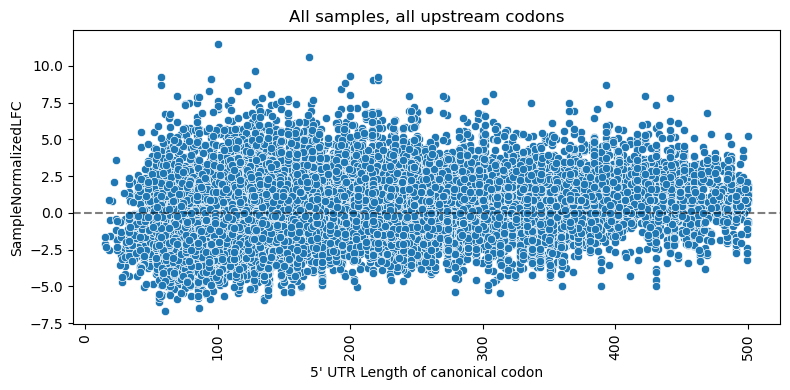

In [78]:
# zoom on [0, 500]
utr_binned_tis_df = paired_tis_df[
    paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) & 
    (paired_tis_df['CanonicalStart'] <= 500)
].copy()
utr_binned_tis_df['UTRLengthBin'] = pd.cut(utr_binned_tis_df['CanonicalStart'], bins=np.arange(0, utr_binned_tis_df['CanonicalStart'].max() + 20, 20))

plt.figure(figsize=(8, 4))

sns.scatterplot(
    utr_binned_tis_df,
    x='CanonicalStart', y='SampleNormalizedLFC',
)
plt.gca().axhline(0, linestyle='dashed', color='black', alpha=0.5)
plt.gca().set_title(f'All samples, all upstream codons')
plt.gca().set_xlabel("5' UTR Length of canonical codon")
plt.gca().tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()


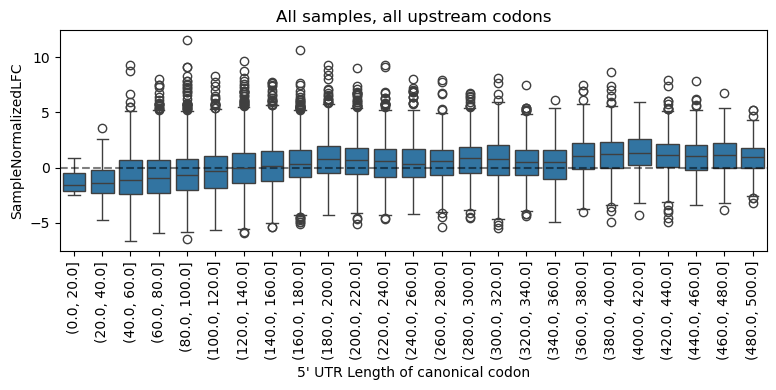

In [ ]:
# zoom on [0, 500]
utr_binned_tis_df = paired_tis_df[
    paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) & 
    (paired_tis_df['CanonicalStart'] <= 500)
].copy()
utr_binned_tis_df['UTRLengthBin'] = pd.cut(utr_binned_tis_df['CanonicalStart'], bins=np.arange(0, utr_binned_tis_df['CanonicalStart'].max() + 20, 20))

plt.figure(figsize=(8, 4))

sns.boxplot(
    utr_binned_tis_df,
    x='UTRLengthBin', y='SampleNormalizedLFC',
)
plt.gca().axhline(0, linestyle='dashed', color='black', alpha=0.5)
plt.gca().set_title(f'All samples, all upstream codons')
plt.gca().set_xlabel("5' UTR Length of canonical codon")
plt.gca().tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()


Observations: 
1) Regardless of upstream start codon identity, there is less efficient upstream translation within the 5' UTR region as the 5' UTR gets shorter. 
2) For AUG, the reduction in efficiency is weaker (possibly counteracted by the strength of initiation binding). For CUG, the reduction in efficiency is stronger.
3) The median efficiency in longer UTRs is above 0, because we are biased in detecting high-low readcount patterns in upstream-canonical TIS biased against detecting low-high patterns. i.e. if either the upstream or the canonical site has 0 readcounts, we can assign 0 to the canonical site because its location is annotated, but we cannot identify upsteam sites from annotations

2 possible interpretations:
1) All transcripts need a sufficiently long UTR to initiate translation, including for translation of extensions; as a result, the relative efficiency of shorter UTRs is lower
2) There are some artifactual reads captured in a short distance upstream of the true translation site; the relatively low efficiency signal in this region is a result of leaky noise rather than a weaker alternative upstream TIS.


In [173]:
utr_binned_tis_df = paired_tis_df[
    paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])
].copy()
utr_binned_tis_df['UTRLengthBin'] = pd.cut(utr_binned_tis_df['CanonicalStart'], bins=np.arange(0, utr_binned_tis_df['CanonicalStart'].max() + 50, 50))

medians_by_sample = utr_binned_tis_df.groupby(['Sample', 'UTRLengthBin'])['SampleNormalizedLFC'].median()
medians_by_codon = utr_binned_tis_df.groupby(['StartCodon', 'UTRLengthBin'])['SampleNormalizedLFC'].median()
medians_by_sample_codon = utr_binned_tis_df.groupby(['Sample', 'StartCodon', 'UTRLengthBin'])['SampleNormalizedLFC'].median()

Text(0.5, 1.0, "Relative expression at upstream TIS vs.\n5' UTR length of transcript for canonical isoform")

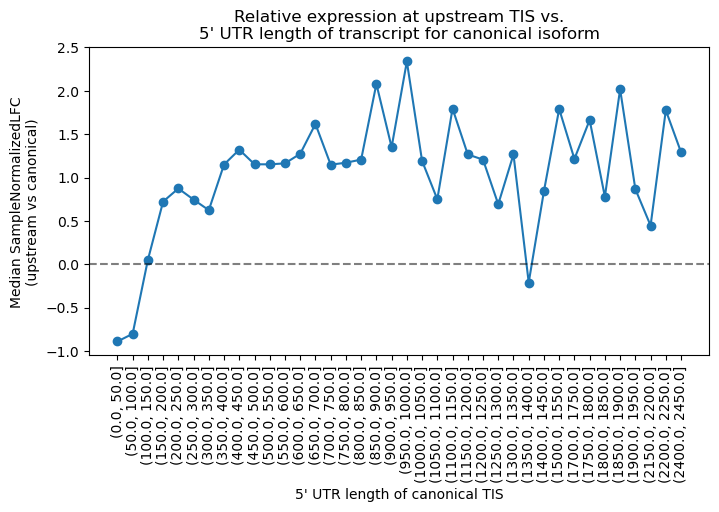

In [186]:
plt.figure(figsize=(8, 4))
medians = medians_by_sample.groupby(level=1).median().reset_index()
xlabel_order = medians['UTRLengthBin'].sort_values().unique().tolist()
xlabel_indices = np.arange(0, len(xlabel_order))
medians['xindex'] = xlabel_indices
x = medians['xindex'].tolist()
y = medians['SampleNormalizedLFC'].tolist()
plt.plot(x, y, 'o-', label=s)
plt.xlabel("5' UTR length of canonical TIS")
plt.ylabel("Median SampleNormalizedLFC\n(upstream vs canonical)")
plt.xticks(xlabel_indices, xlabel_order, rotation=90)
plt.gca().axhline(0, linestyle='dashed', color='black', alpha=0.5)
plt.title("Relative expression at upstream TIS vs.\n5' UTR length of transcript for canonical isoform")

Text(0.5, 1.0, "Relative expression at upstream TIS vs.\n5' UTR length of transcript for canonical isoform")

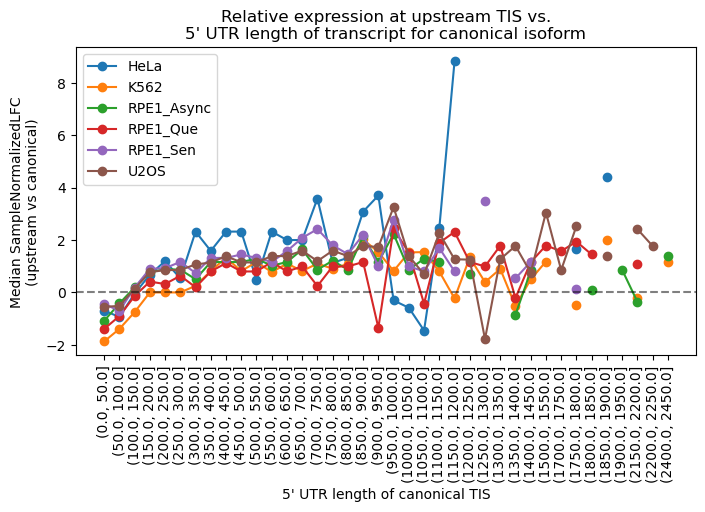

In [177]:
plt.figure(figsize=(8, 4))
xlabel_order = medians_by_sample.reset_index()['UTRLengthBin'].sort_values().unique().tolist()
xlabel_indices = np.arange(0, len(xlabel_order))
for s in samples:
    aligned_df = medians_by_sample.loc[s, :].reindex(index=xlabel_order).reset_index()
    aligned_df['xindex'] = xlabel_indices
    x = aligned_df['xindex'].tolist()
    y = aligned_df['SampleNormalizedLFC'].tolist()
    plt.plot(x, y, 'o-', label=s)
plt.xlabel("5' UTR length of canonical TIS")
plt.ylabel("Median SampleNormalizedLFC\n(upstream vs canonical)")
plt.xticks(xlabel_indices, xlabel_order, rotation=90)
plt.gca().axhline(0, linestyle='dashed', color='black', alpha=0.5)
plt.legend()
plt.title("Relative expression at upstream TIS vs.\n5' UTR length of transcript for canonical isoform")

Text(0.5, 1.0, "Relative expression at upstream TIS vs.\n5' UTR length of transcript for canonical isoform")

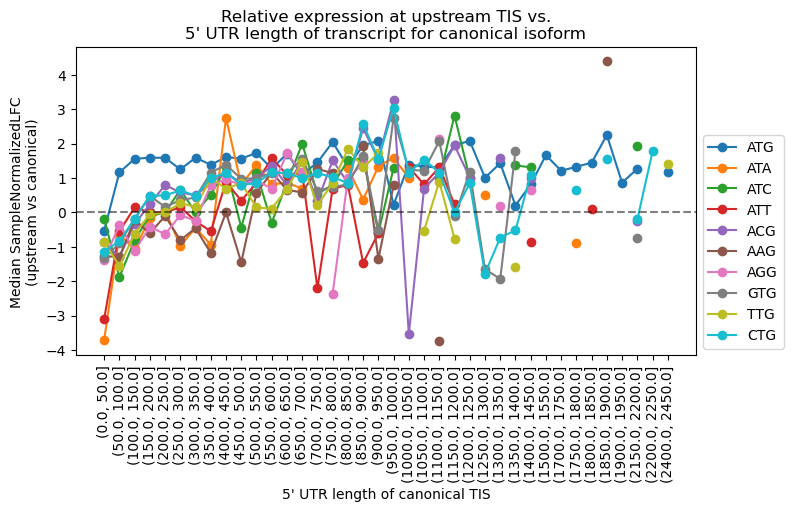

In [179]:
plt.figure(figsize=(8, 4))
xlabel_order = medians_by_codon.reset_index()['UTRLengthBin'].sort_values().unique().tolist()
xlabel_indices = np.arange(0, len(xlabel_order))
for c in codon_order:
    aligned_df = medians_by_codon.loc[c, :].reindex(index=xlabel_order).reset_index()
    aligned_df['xindex'] = xlabel_indices
    x = aligned_df['xindex'].tolist()
    y = aligned_df['SampleNormalizedLFC'].tolist()
    plt.plot(x, y, 'o-', label=c)
plt.xlabel("5' UTR length of canonical TIS")
plt.ylabel("Median SampleNormalizedLFC\n(upstream vs canonical)")
plt.xticks(xlabel_indices, xlabel_order, rotation=90)
plt.gca().axhline(0, linestyle='dashed', color='black', alpha=0.5)
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.title("Relative expression at upstream TIS vs.\n5' UTR length of transcript for canonical isoform")

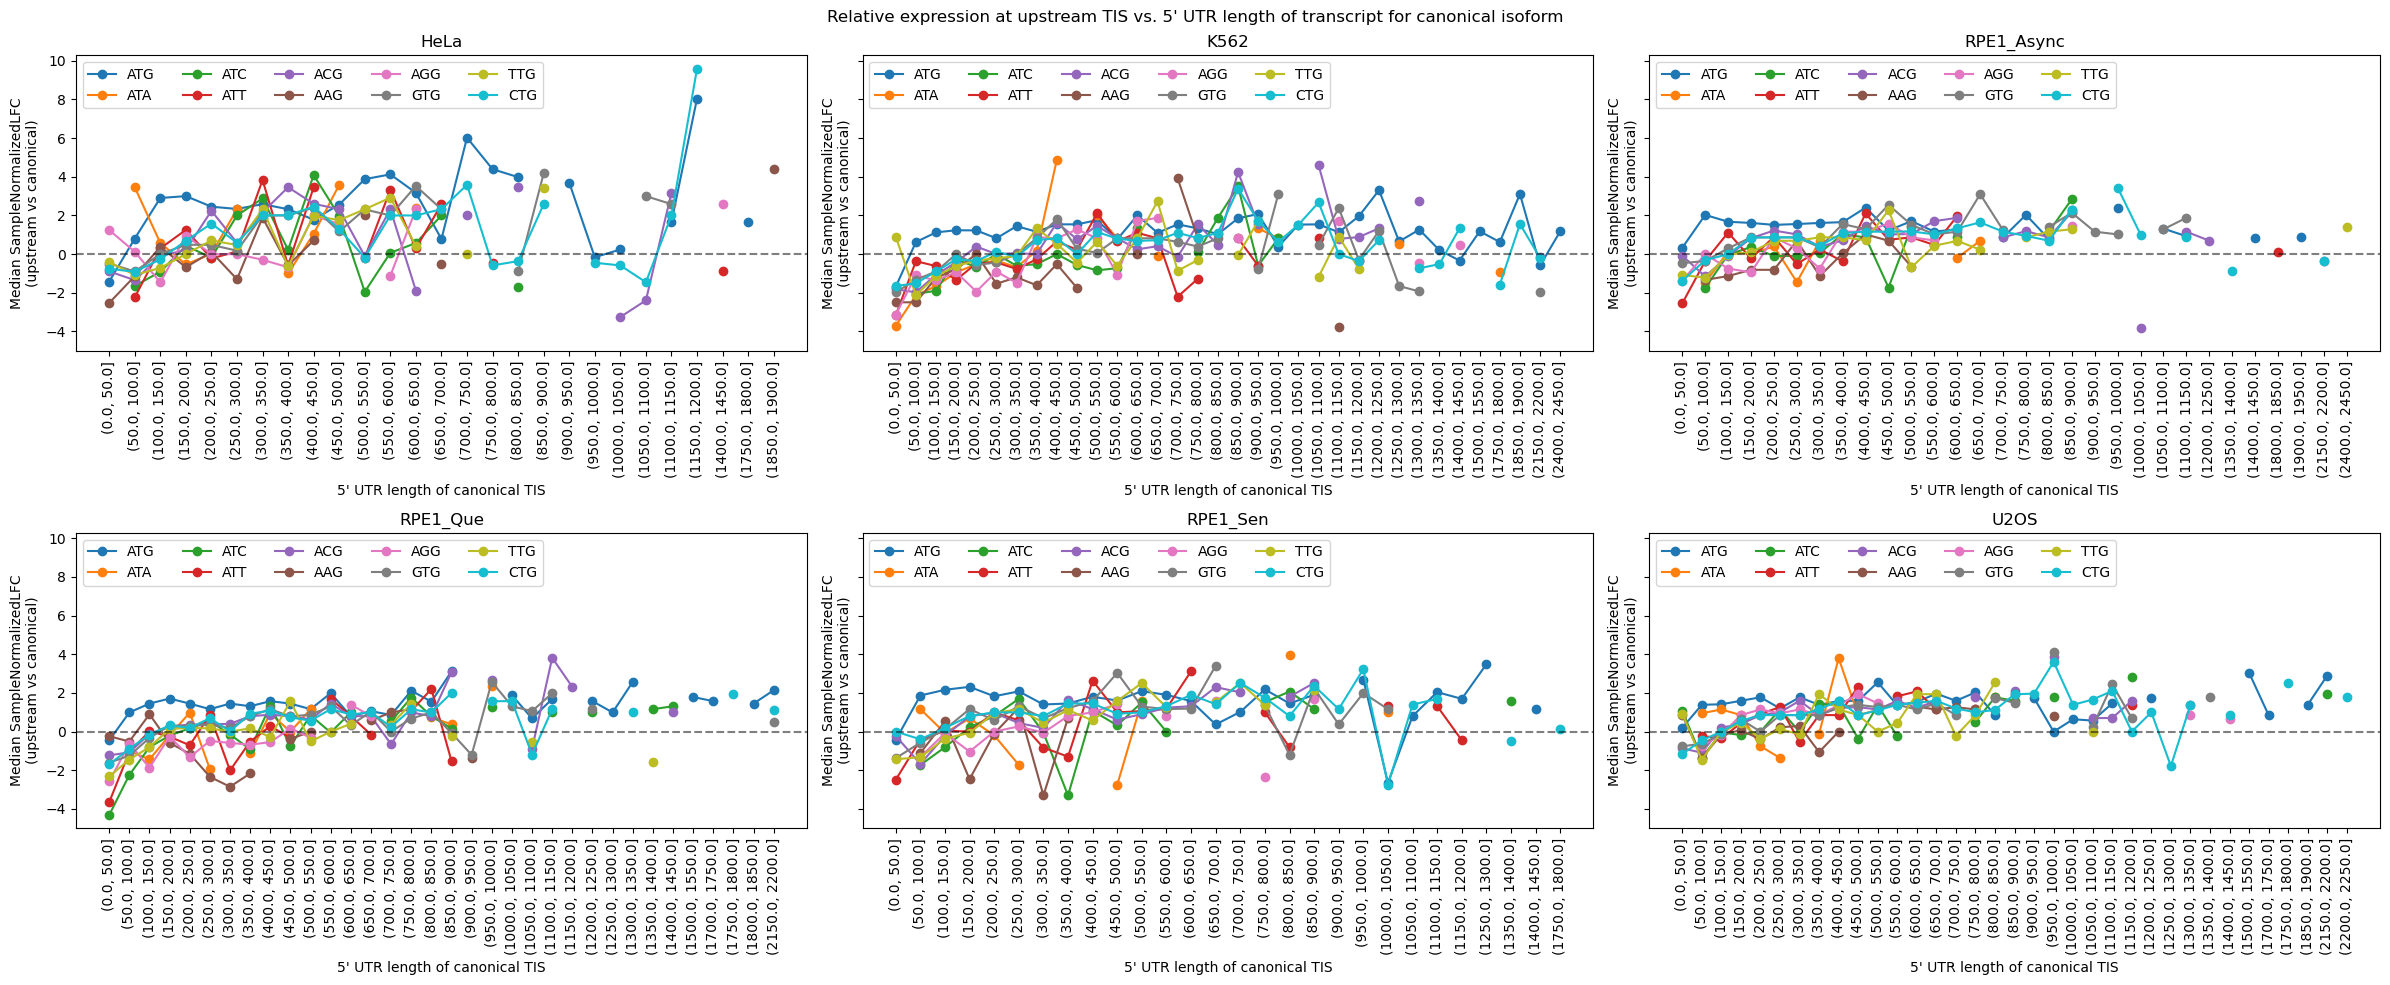

In [180]:
fig, axs = plt.subplots(2, 3, figsize=(24, 10), sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sample_subset = medians_by_sample_codon.loc[s, :]
    xlabel_order = sample_subset.reset_index()['UTRLengthBin'].sort_values().unique().tolist()
    xlabel_indices = np.arange(0, len(xlabel_order))
    for c in codon_order:
        aligned_df = sample_subset.loc[c, :].reindex(index=xlabel_order).reset_index()
        aligned_df['xindex'] = xlabel_indices
        x = aligned_df['xindex'].tolist()
        y = aligned_df['SampleNormalizedLFC'].tolist()
        axs[i].plot(x, y, 'o-', label=c)
    axs[i].set_xlabel("5' UTR length of canonical TIS")
    axs[i].set_ylabel("Median SampleNormalizedLFC\n(upstream vs canonical)")
    axs[i].set_xticks(xlabel_indices, xlabel_order, rotation=90)
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(s)
    axs[i].legend(loc='upper left', ncol=5)
plt.suptitle("Relative expression at upstream TIS vs. 5' UTR length of transcript for canonical isoform")
plt.tight_layout()
plt.show()

# Relationship between translation efficiency and gene expression

/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Riboseq log2(RPM)')

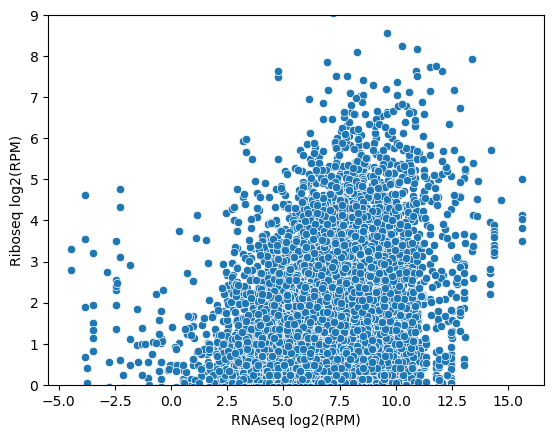

In [218]:
sns.scatterplot(
    x=np.log2((paired_tis_df['GeneRNASeqCounts'] / paired_tis_df['TotalRNASeqCounts']) * 1e6),
    y=np.log2(paired_tis_df['NormTISCounts'])
)
plt.ylim(0, 9)
plt.xlabel('RNAseq log2(RPM)')
plt.ylabel('Riboseq log2(RPM)')

In [227]:
print('corr:')
print(
    pd.concat([
        np.log2((paired_tis_df['GeneRNASeqCounts'] / paired_tis_df['TotalRNASeqCounts']) * 1e6),
        np.log2(paired_tis_df['NormTISCounts'])
    ], axis=1).dropna().corr().iloc[0, 1]
)

corr:
0.33743554781987434


/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [212]:
paired_tis_df[(paired_tis_df['GeneRNASeqCounts'] / paired_tis_df['TotalRNASeqCounts']) > 0.01]

Sample                 Gid                 Tid Symbol  \
45948  RPE1_Async  ENSG00000115414.22  ENST00000354785.11    FN1   
45949  RPE1_Async  ENSG00000115414.22  ENST00000354785.11    FN1   
45950  RPE1_Async  ENSG00000115414.22  ENST00000354785.11    FN1   
45951  RPE1_Async  ENSG00000115414.22  ENST00000354785.11    FN1   
45952  RPE1_Async  ENSG00000115414.22  ENST00000354785.11    FN1   
45953  RPE1_Async  ENSG00000115414.22  ENST00000354785.11    FN1   
49176  RPE1_Async  ENSG00000026025.17   ENST00000544301.7    VIM   
57066    RPE1_Que  ENSG00000115414.22  ENST00000354785.11    FN1   
57067    RPE1_Que  ENSG00000115414.22  ENST00000354785.11    FN1   
57068    RPE1_Que  ENSG00000115414.22  ENST00000354785.11    FN1   
57069    RPE1_Que  ENSG00000115414.22  ENST00000354785.11    FN1   
57070    RPE1_Que  ENSG00000115414.22  ENST00000354785.11    FN1   
59505    RPE1_Que  ENSG00000113140.12   ENST00000231061.9  SPARC   
59506    RPE1_Que  ENSG00000113140.12   ENST00000231061.9  SPARC   
62372    RPE1_Que  ENSG00000026025.17   ENST00000544301.7    VIM   
65808    RPE1_Que  ENSG00000137801.12   ENST00000260356.6  THBS1   
65809    RPE1_Que  ENSG00000137801.12   ENST00000260356.6  THBS1   
65810    RPE1_Que  ENSG00000137801.12   ENST00000260356.6  THBS1   
65811    RPE1_Que  ENSG00000137801.12   ENST00000260356.6  THBS1   
65812    RPE1_Que  ENSG00000137801.12   ENST00000260356.6  THBS1   
65813    RPE1_Que  ENSG00000137801.12   ENST00000260356.6  THBS1   
65814    RPE1_Que  ENSG00000137801.12   ENST00000260356.6  THBS1   
65815    RPE1_Que  ENSG00000137801.12   ENST00000260356.6  THBS1   
65881    RPE1_Que  ENSG00000166147.16  ENST00000316623.10   FBN1   
65882    RPE1_Que  ENSG00000166147.16  ENST00000316623.10   FBN1   
65883    RPE1_Que  ENSG00000166147.16  ENST00000316623.10   FBN1   
65884    RPE1_Que  ENSG00000166147.16  ENST00000316623.10   FBN1   
65885    RPE1_Que  ENSG00000166147.16  ENST00000316623.10   FBN1   
72393    RPE1_Sen  ENSG00000115414.22  ENST00000354785.11    FN1   
76161    RPE1_Sen  ENSG00000026025.17   ENST00000544301.7    VIM   
76162    RPE1_Sen  ENSG00000026025.17   ENST00000544301.7    VIM   

             GeneType                   GenomePos     GenomeStart   Start  \
45948  protein_coding  chr2:215361554-215435985:-  chr2:215435985    83.0   
45949  protein_coding  chr2:215361554-215435895:-  chr2:215435895   173.0   
45950  protein_coding  chr2:215361554-215435871:-  chr2:215435871   197.0   
45951  protein_coding  chr2:215361554-215435865:-  chr2:215435865   203.0   
45952  protein_coding  chr2:215361554-215435733:-  chr2:215435733   335.0   
45953  protein_coding  chr2:215361554-215364977:-  chr2:215364977  7418.0   
49176  protein_coding   chr10:17229313-17229757:+  chr10:17229313   322.0   
57066  protein_coding  chr2:215361554-215435985:-  chr2:215435985    83.0   
57067  protein_coding  chr2:215361554-215435895:-  chr2:215435895   173.0   
57068  protein_coding  chr2:215361554-215435853:-  chr2:215435853   215.0   
57069  protein_coding  chr2:215361554-215435733:-  chr2:215435733   335.0   
57070  protein_coding  chr2:215361554-215364977:-  chr2:215364977  7418.0   
59505  protein_coding  chr5:151663570-151686869:-  chr5:151686869    46.0   
59506  protein_coding  chr5:151674654-151686912:-  chr5:151686912     3.0   
62372  protein_coding   chr10:17229313-17229757:+  chr10:17229313   322.0   
65808  protein_coding   chr15:39581116-39595369:+  chr15:39581116    38.0   
65809  protein_coding   chr15:39581158-39595369:+  chr15:39581158    80.0   
65810  protein_coding   chr15:39581833-39595369:+  chr15:39581833   155.0   
65811  protein_coding   chr15:39581836-39595369:+  chr15:39581836   158.0   
65812  protein_coding   chr15:39589828-39595369:+  chr15:39589828  2129.0   
65813  protein_coding   chr15:39593512-39595369:+  chr15:39593512  3290.0   
65814  protein_coding   chr15:39593560-39595369:+  chr15:39593560  3338.0   
65815  protein_coding   chr15:39594182-39595369:+  chr15:395941

Most highly expressed genes are cell adhesion / ECM genes: FN1 (fibronectin), FBN1 (fibrillin), VIM (fimentin), SPARC (osteonectin), THBS1 (thrombospondin)

/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'RNAseq log2(RPM)')

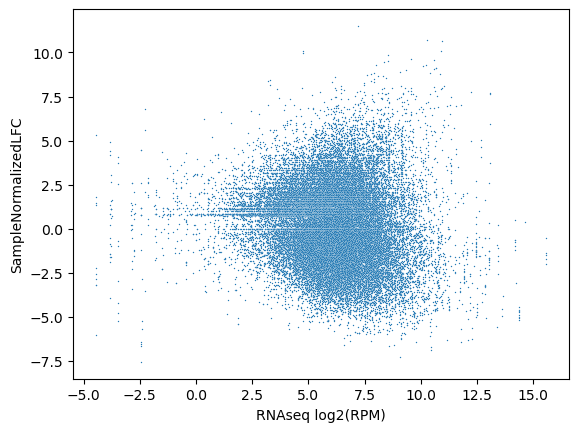

In [232]:
sns.scatterplot(
    x=np.log2((paired_tis_df['GeneRNASeqCounts'] / paired_tis_df['TotalRNASeqCounts']) * 1e6),
    y=paired_tis_df['SampleNormalizedLFC'],
    s=1
)
plt.xlabel('RNAseq log2(RPM)')